# Práctica Calificada 2
---
**Predicción de tarifas de taxis**<br>
El objetivo de esta evaluación es construir un modelo de aprendizaje que sea capaz de
predecir la tarifa que cobra un taxi de acuerdo a cierta información de entrada.

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, average_precision_score, precision_recall_curve
from inspect import signature
from math import sqrt, sin, cos, asin, pi
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import matplotlib.pyplot as plt
%matplotlib inline

* **ID**: cadena que identifica de manera única a cada registro
* **pickup_datetime**: timestamp indicando cuando el viaje a empezado
* **pickup_longitude**: número real indicando la ubicación en **longitud** en donde el viaje
empezó
* **pickup_latitude**: número real indicando la ubicación en **latitud** en donde el viaje
empezó
* **dropoff_longitude**: número real indicando la ubicación en longitud en donde el viaje
terminó
* **dropoff_latitude**: número real indicando la ubicación en latitud en donde el viaje
terminó
* **passenger_count**: número entero indicando el número de pasajeros en el servicio de
taxi
* **fare_amount: número real indicando el costo del taxi. Esta es la variable a predecir**

<h4>Poblacion</h4>

In [6]:
%%time
df = pd.read_csv("100k_train.csv") # cambiar esto por train.csv para cargar los 55M .

Wall time: 343 ms


In [7]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+05,100000.000000,100000.000000,100000.000000,99999.000000,99999.000000,100000.000000
mean,2.771124e+07,11.336822,-72.471349,39.895982,-72.495088,39.905861,1.683360
std,1.601008e+07,9.707742,10.587718,6.423522,10.735315,6.394699,1.306758
min,2.030000e+02,-8.500000,-83.353842,-74.017740,-736.500000,-74.015572,0.000000
25%,1.384279e+07,6.000000,-73.992120,40.734982,-73.991362,40.734040,1.000000
50%,2.773127e+07,8.500000,-73.981845,40.752628,-73.980120,40.753255,1.000000
75%,4.157677e+07,12.500000,-73.967078,40.767047,-73.963554,40.768178,2.000000
max,5.542340e+07,238.000000,40.800855,404.666667,40.869710,404.383332,8.000000


<h4>Muestra</h4>

In [8]:
%%time
# 1000000 sample
df_s = df.sample(100000, random_state = 7)

Wall time: 47.8 ms


In [9]:
df_s.head(5)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
33909,6995983,2010-04-09 21:07:00.00000031,12.9,2010-04-09 21:07:00 UTC,-73.982005,40.755532,-73.986393,40.722167,1
92307,50914033,2010-04-27 13:01:26.0000005,8.9,2010-04-27 13:01:26 UTC,-73.992916,40.747968,-73.990090,40.771926,1
89107,1385641,2013-04-12 01:00:00.000000149,15.0,2013-04-12 01:00:00 UTC,-73.993250,40.738415,-73.948227,40.773012,1
9538,32496265,2011-12-12 20:17:00.000000268,7.3,2011-12-12 20:17:00 UTC,-73.987408,40.719842,-74.009960,40.728983,1
31008,28151968,2009-12-25 00:37:33.0000001,15.7,2009-12-25 00:37:33 UTC,-73.925891,40.761700,-73.999438,40.730170,3


In [10]:
df_s.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+05,100000.000000,100000.000000,100000.000000,99999.000000,99999.000000,100000.000000
mean,2.771124e+07,11.336822,-72.471349,39.895982,-72.495088,39.905861,1.683360
std,1.601008e+07,9.707742,10.587718,6.423522,10.735315,6.394699,1.306758
min,2.030000e+02,-8.500000,-83.353842,-74.017740,-736.500000,-74.015572,0.000000
25%,1.384279e+07,6.000000,-73.992120,40.734982,-73.991362,40.734040,1.000000
50%,2.773127e+07,8.500000,-73.981845,40.752628,-73.980120,40.753255,1.000000
75%,4.157677e+07,12.500000,-73.967078,40.767047,-73.963554,40.768178,2.000000
max,5.542340e+07,238.000000,40.800855,404.666667,40.869710,404.383332,8.000000


In [11]:
df_s.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

<h4>Data Cleaning y Transformación de la Data</h4>

In [77]:
# Se trabajará con la siguiente data

data = df_s[(-180.0 <= df_s["pickup_longitude"]) & (df_s["pickup_longitude"] <= 180.0) &
            (-90.0 <= df_s["pickup_latitude"]) & (df_s["pickup_latitude"] <= 90.0) & 
            (-180.0 <= df_s["dropoff_longitude"]) & (df_s["dropoff_longitude"] <= 180.0) &
            (-90.0 <= df_s["dropoff_latitude"]) & (df_s["dropoff_latitude"] <= 90.0)&
            (2.0 <= df_s["fare_amount"]) & (df_s["fare_amount"] <= 200) & 
            (0.0<=df_s["passenger_count"]) & (df_s["passenger_count"]<= 8)]

data = df_s.query('pickup_latitude > 40.7 and pickup_latitude < 40.8 and ' +
                  'dropoff_latitude > 40.7 and dropoff_latitude < 40.8 and ' +
                  'pickup_longitude > -74 and pickup_longitude < -73.9 and ' +
                  'dropoff_longitude > -74 and dropoff_longitude < -73.9 and ' +
                  'fare_amount > 0 and ' +
                  '0 < passenger_count and passenger_count < 6 and '
                  'pickup_longitude != dropoff_longitude')
data ['pickup_datetime'] = pd.to_datetime(data.pickup_datetime) # convertimos a tipo de dato de datetime
data['year'] = data['pickup_datetime'].dt.year
data['month'] = data['pickup_datetime'].dt.month
data['day'] = data['pickup_datetime'].dt.day
data['hour'] = data['pickup_datetime'].dt.hour

data.drop(columns='key', inplace=True)
data.drop(columns='pickup_datetime', inplace=True)

data.head(5)

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
33909,6995983,12.9,-73.982005,40.755532,-73.986393,40.722167,1,2010,4,9,21
92307,50914033,8.9,-73.992916,40.747968,-73.990090,40.771926,1,2010,4,27,13
89107,1385641,15.0,-73.993250,40.738415,-73.948227,40.773012,1,2013,4,12,1
31008,28151968,15.7,-73.925891,40.761700,-73.999438,40.730170,3,2009,12,25,0
71012,45827401,9.7,-73.991498,40.750039,-73.961549,40.765086,2,2011,4,3,19


In [73]:
data.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance
count,6.256000e+04,62560.000000,62560.000000,62560.000000,62560.000000,62560.000000,62560.000000,62560.000000,62560.000000,62560.000000,62560.000000,62560.000000
mean,2.771170e+07,8.444673,-73.976909,40.756826,-73.975355,40.757361,1.675240,2011.717423,6.260134,15.757577,13.618238,2.147146
std,1.601442e+07,4.348403,0.014582,0.018167,0.015816,0.018775,1.302973,1.866749,3.460603,8.709695,6.298641,1.463374
min,3.940000e+02,0.010000,-73.999998,40.700187,-73.999997,40.700032,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000084
25%,1.385302e+07,5.500000,-73.988113,40.744803,-73.987195,40.745575,1.000000,2010.000000,3.000000,8.000000,9.000000,1.096788
50%,2.776033e+07,7.500000,-73.979728,40.757792,-73.978457,40.758381,1.000000,2012.000000,6.000000,16.000000,14.000000,1.770558
75%,4.157344e+07,10.100000,-73.967866,40.769333,-73.966166,40.770435,2.000000,2013.000000,9.000000,23.000000,19.000000,2.826596
max,5.542340e+07,76.700000,-73.900822,40.799988,-73.900013,40.799990,6.000000,2015.000000,12.000000,31.000000,23.000000,11.115543


In [78]:
data.shape

(60307, 11)

In [72]:
data.sort_values(by='pickup_longitude', ascending=False).tail(5)

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance
81641,25185173,7.3,-73.999993,40.733058,-73.980640,40.742148,3,2009,1,31,22,1.918523
75792,3001635,10.1,-73.999995,40.761515,-73.986602,40.740430,1,2009,10,20,13,2.602000
7809,42014395,8.0,-73.999995,40.732982,-73.989835,40.756537,1,2013,2,8,19,2.755651
62273,27164587,3.7,-73.999997,40.738665,-73.991548,40.735117,3,2011,8,25,17,0.813919
55764,49641654,6.5,-73.999998,40.761388,-73.983342,40.752543,1,2012,4,23,13,1.713414


<AxesSubplot:>

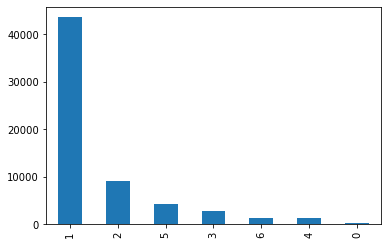

In [52]:
data["passenger_count"].value_counts().plot(kind="bar")

<AxesSubplot:xlabel='fare_amount', ylabel='Frequency'>

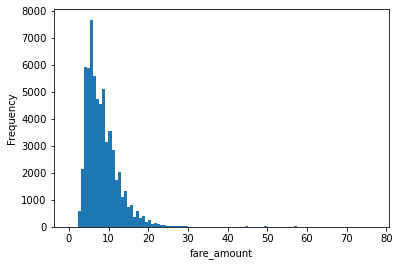

In [53]:
plt.xlabel("fare_amount")
data["fare_amount"].plot.hist(alpha=1, stacked=True, bins=100)

<AxesSubplot:xlabel='pickup_longitude', ylabel='pickup_latitude'>

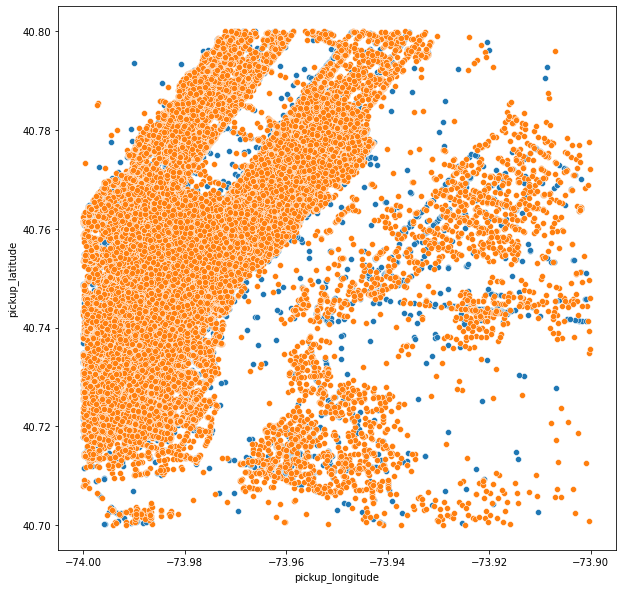

In [79]:
plt.figure(figsize = (10, 10))
sns.scatterplot(data["pickup_longitude"], data["pickup_latitude"])
sns.scatterplot(data["dropoff_longitude"], data["dropoff_latitude"])

<h4>Ingeniería de Características</h4>

In [86]:
#Distancia entre dos puntos (Métrica de Haversine)
# two ways 
# 1  : Using the package

#from haversine import haversine
#origin = (39.50, 98.35)
#paris = (48.8567, 2.3508)
#haversine(origin, paris, miles=False) # return the distance in km

# 2 def a function

def radian(sexag):
    return sexag*(pi/180.0)

def Haversine(lat1,lon1,lat2,lon2):
    if (lat1 == lat2 and lon1 == lon2):
        return 0.0001 # por mientras
    diffLat = radian(lat2-lat1)
    diffLon = radian(lon2-lon1)
    h = sin(diffLat/2) ** 2 + cos(radian(lat1))*cos(radian(lat2))*(sin(diffLon/2)**2)
    dKm = 2.0 * 6371.345 * asin(sqrt(h))
    return dKm 

#print(Haversine(39.50, 98.35, 48.8567, 2.3508))

data['distance'] = data.apply(lambda row: Haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
data.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance
count,6.030700e+04,60307.000000,60307.000000,60307.000000,60307.000000,60307.000000,60307.000000,60307.000000,60307.000000,60307.000000,60307.000000,60307.000000
mean,2.773688e+07,8.432106,-73.976991,40.756831,-73.975402,40.757371,1.586499,2011.697315,6.259290,15.756314,13.629031,2.172271
std,1.601651e+07,4.273686,0.014468,0.018168,0.015740,0.018788,1.146974,1.871820,3.460631,8.709003,6.297288,1.453033
min,3.940000e+02,0.010000,-73.999998,40.700187,-73.999997,40.700032,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000084
25%,1.388393e+07,5.500000,-73.988120,40.744795,-73.987188,40.745592,1.000000,2010.000000,3.000000,8.000000,9.000000,1.117245
50%,2.778259e+07,7.500000,-73.979781,40.757795,-73.978463,40.758401,1.000000,2012.000000,6.000000,16.000000,14.000000,1.786955
75%,4.160038e+07,10.100000,-73.967965,40.769329,-73.966232,40.770510,2.000000,2013.000000,9.000000,23.000000,19.000000,2.843777
max,5.542340e+07,76.700000,-73.900822,40.799988,-73.900013,40.799987,5.000000,2015.000000,12.000000,31.000000,23.000000,11.115543


<h4> Definición del modelo a entrenar </h4>

In [83]:
predictors = ['distance']
salida = 'fare_amount'

X = data[predictors]
y = data[salida]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Imprime el b y lso coeficientes
print(f'Intercepto: {modelo.intercept_:.3f}')
print(f'Coeficientes: {modelo.coef_[0]:.3f}')

Intercepto: 3.876
Coeficientes: 2.097


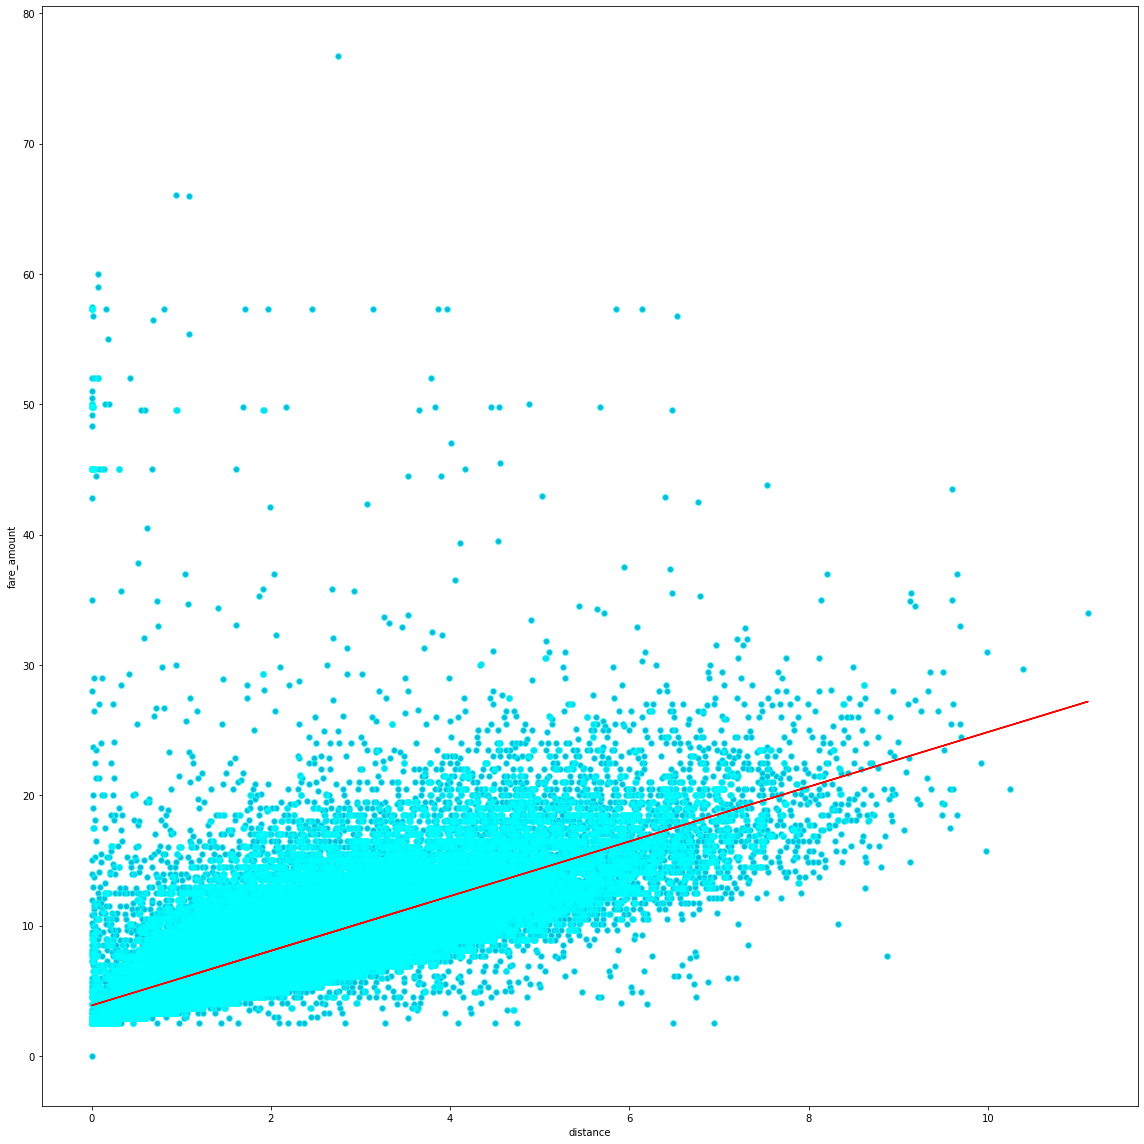

In [84]:
# comparo el valor predicho de todos los puntos dados con el calculado
fitted = modelo.predict(data[predictors])
residuals = data[salida] - fitted

ax = data.plot.scatter(x="distance", y="fare_amount", figsize=(16, 16))
ax.scatter(data.distance, data.fare_amount, alpha=0.5, c='aqua')
ax.plot(data.distance, fitted, c="red")
"""
for x, y_actual, y_fitted in zip(data.distance, data.fare_amount, fitted):
    ax.plot((x, x), (y_actual, y_fitted), "--", color="C1")
"""    
plt.tight_layout()
plt.show()

In [85]:
modelo.score(X_test, y_test)

0.4972945762482923